# Cointegration Testing

This notebook tests for cointegration relationships among the variables in the cleaned dataset. Cointegration tests help identify long-run equilibrium relationships between non-stationary variables.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.4f}'.format)

## Load Clean Data

Load the cleaned dataset (before any differencing transformations) to test for cointegration among non-stationary variables.

In [20]:
# Load the clean data (non-differenced)
df_clean = pd.read_csv('../data/df_clean.csv', index_col=0, parse_dates=True)

# Drop D0_USA to avoid multicollinearity (since D0 + D1 + D2 + D3 + D4 = 100%)
# Keep D1_USA, D2_USA, D3_USA, D4_USA as separate variables
df_clean = df_clean.drop(columns=['D0_USA'])

print("Clean Dataset Loaded")
print("="*80)
print(f"Shape: {df_clean.shape}")
print(f"Date range: {df_clean.index.min()} to {df_clean.index.max()}")

print(f"\nNote: Dropped D0_USA to avoid multicollinearity")
print(f"      Keeping D1_USA, D2_USA, D3_USA, D4_USA as separate variables")
print(f"\nColumns: {list(df_clean.columns)}")
print(f"\nFirst few rows:")
display(df_clean.head())

Clean Dataset Loaded
Shape: (242, 17)
Date range: 2002-11-01 00:00:00 to 2022-12-01 00:00:00

Note: Dropped D0_USA to avoid multicollinearity
      Keeping D1_USA, D2_USA, D3_USA, D4_USA as separate variables

Columns: ['PMAIZMTUSDM', 'PBEEFUSDM', 'PPORKUSDM', 'PLAMBUSDM', 'PPOULTUSDM', 'POILBREUSDM', 'fao_food_index', 'bioethanol_production', 'retail_china', 'fnbretail_USA', 'D1_USA', 'D2_USA', 'D3_USA', 'D4_USA', 'cdd_BR', 'precip_BR', 'enso_anomaly']

First few rows:


,PMAIZMTUSDM,PBEEFUSDM,PPORKUSDM,PLAMBUSDM,PPOULTUSDM,POILBREUSDM,fao_food_index,bioethanol_production,retail_china,fnbretail_USA,D1_USA,D2_USA,D3_USA,D4_USA,cdd_BR,precip_BR,enso_anomaly
index,,,,,,,,,,,,,,,,,
2002-11-01,108.6464,81.5625,40.6021,154.9612,61.9048,24.2505,56.6000,166.0000,383110.0000,27058.0000,13.3400,10.7600,10.0900,0.7400,7.3300,140.4100,1.4100
2002-12-01,107.0126,84.0000,43.6720,157.9364,61.4886,28.3173,56.0000,176.0000,427020.0000,27440.0000,9.5300,12.8500,10.4400,0.8400,5.9100,218.9700,1.3100
2003-01-01,105.8443,85.3500,46.5835,162.6902,62.2536,30.8087,56.2000,177.0000,408710.0000,27263.0000,10.4200,8.9500,15.2600,2.0000,4.7100,219.0300,0.7000
2003-02-01,106.1411,83.7500,48.1642,159.7043,63.0625,32.6625,56.9000,169.0000,385660.0000,27165.0000,10.3300,10.2400,14.9900,1.7300,4.5100,207.7600,0.7400
2003-03-01,105.1319,83.8750,48.8385,153.1048,63.8413,30.1681,55.9000,175.0000,364520.0000,27611.0000,11.8600,11.8200,12.3400,0.4600,3.8800,236.6100,0.4500


## Identify Non-Stationary Variables

First, we need to identify which variables are non-stationary (I(1)) to test for cointegration. Variables must be integrated of the same order to be cointegrated.

In [21]:
def test_stationarity(series, alpha=0.05):
    """
    Perform Augmented Dickey-Fuller test for stationarity.
    """
    result = adfuller(series.dropna(), autolag='AIC')
    return {
        'ADF Statistic': result[0],
        'p-value': result[1],
        'Lags Used': result[2],
        'Observations': result[3],
        'Critical Value (1%)': result[4]['1%'],
        'Critical Value (5%)': result[4]['5%'],
        'Critical Value (10%)': result[4]['10%'],
        'Stationary': 'Yes' if result[1] < alpha else 'No'
    }

# Test all variables for stationarity
adf_results = {}
for col in df_clean.columns:
    adf_results[col] = test_stationarity(df_clean[col])

adf_df = pd.DataFrame(adf_results).T
print("\nAugmented Dickey-Fuller Test Results")
print("="*80)
display(adf_df)

# Identify non-stationary variables
non_stationary_vars = adf_df[adf_df['Stationary'] == 'No'].index.tolist()
print(f"\nNon-stationary variables (I(1)): {len(non_stationary_vars)}")
for i, var in enumerate(non_stationary_vars, 1):
    print(f"  {i}. {var}")


Augmented Dickey-Fuller Test Results


,ADF Statistic,p-value,Lags Used,Observations,Critical Value (1%),Critical Value (5%),Critical Value (10%),Stationary
PMAIZMTUSDM,-1.8987,0.3327,1,240,-3.4579,-2.8737,-2.5732,No
PBEEFUSDM,-1.8219,0.3697,4,237,-3.4582,-2.8738,-2.5733,No
PPORKUSDM,-4.5673,0.0001,1,240,-3.4579,-2.8737,-2.5732,Yes
PLAMBUSDM,-2.4664,0.1239,3,238,-3.4581,-2.8738,-2.5733,No
PPOULTUSDM,-0.7545,0.8321,15,226,-3.4596,-2.8744,-2.5736,No
POILBREUSDM,-2.8936,0.0461,1,240,-3.4579,-2.8737,-2.5732,Yes
fao_food_index,-2.1282,0.2333,1,240,-3.4579,-2.8737,-2.5732,No
bioethanol_production,-2.1265,0.2340,13,228,-3.4594,-2.8743,-2.5736,No
retail_china,-0.0333,0.9557,15,226,-3.4596,-2.8744,-2.5736,No
fnbretail_USA,1.0146,0.9944,14,227,-3.4595,-2.8744,-2.5736,No



Non-stationary variables (I(1)): 8
  1. PMAIZMTUSDM
  2. PBEEFUSDM
  3. PLAMBUSDM
  4. PPOULTUSDM
  5. fao_food_index
  6. bioethanol_production
  7. retail_china
  8. fnbretail_USA


## Engle-Granger Pairwise Cointegration Test

Test for pairwise cointegration between the target variable (PBEEFUSDM) and each of the other non-stationary variables.

In [22]:
def pairwise_cointegration_test(df, target_var, variables, alpha=0.05):
    """
    Perform Engle-Granger cointegration test between target and each variable.
    """
    results = []
    
    for var in variables:
        if var == target_var:
            continue
        
        # Get clean data for both variables
        data = df[[target_var, var]].dropna()
        
        if len(data) > 30:  # Need sufficient observations
            score, pvalue, crit_value = coint(data[target_var], data[var])
            results.append({
                'Variable': var,
                'Test Statistic': score,
                'p-value': pvalue,
                'Critical Value (5%)': crit_value[1],
                'Cointegrated': 'Yes' if pvalue < alpha else 'No'
            })
    
    return pd.DataFrame(results)

# Test cointegration with PBEEFUSDM
target_var = 'PBEEFUSDM'

if target_var in non_stationary_vars:
    print(f"\nEngle-Granger Pairwise Cointegration Test with {target_var}")
    print("="*80)
    
    coint_results = pairwise_cointegration_test(
        df_clean, 
        target_var, 
        non_stationary_vars
    )
    
    display(coint_results.sort_values('p-value'))
    
    # Identify cointegrated variables
    cointegrated_vars = coint_results[coint_results['Cointegrated'] == 'Yes']['Variable'].tolist()
    print(f"\n✅ Variables cointegrated with {target_var}: {len(cointegrated_vars)}")
    for i, var in enumerate(cointegrated_vars, 1):
        print(f"  {i}. {var}")
else:
    print(f"\n⚠️ {target_var} is stationary - cointegration testing not applicable")


Engle-Granger Pairwise Cointegration Test with PBEEFUSDM


,Variable,Test Statistic,p-value,Critical Value (5%),Cointegrated
2,PPOULTUSDM,-3.5701,0.0267,-3.3616,Yes
1,PLAMBUSDM,-3.0204,0.1054,-3.3616,No
4,bioethanol_production,-2.9470,0.1233,-3.3616,No
5,retail_china,-2.7056,0.1976,-3.3616,No
6,fnbretail_USA,-2.5824,0.2440,-3.3616,No
0,PMAIZMTUSDM,-2.2045,0.4221,-3.3616,No
3,fao_food_index,-1.9639,0.5473,-3.3616,No



✅ Variables cointegrated with PBEEFUSDM: 1
  1. PPOULTUSDM


## Visualize Cointegrating Relationships

Plot the identified cointegrated variable pairs to visualize their long-run relationships.

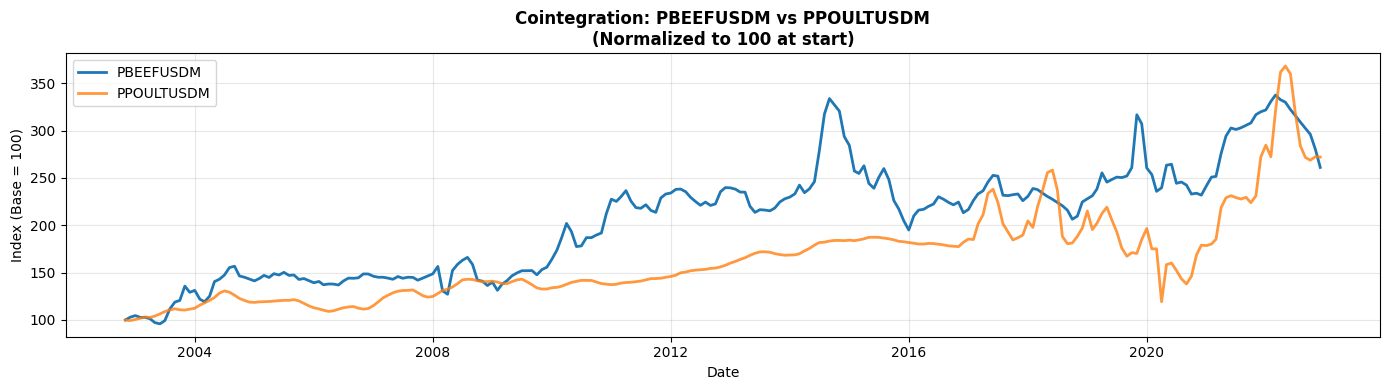

In [23]:
# Visualize cointegrated pairs
if 'cointegrated_vars' in locals() and len(cointegrated_vars) > 0:
    n_plots = min(len(cointegrated_vars), 6)  # Limit to 6 plots
    
    fig, axes = plt.subplots(n_plots, 1, figsize=(14, 4*n_plots))
    if n_plots == 1:
        axes = [axes]
    
    for i, var in enumerate(cointegrated_vars[:n_plots]):
        ax = axes[i]
        
        # Normalize both series to start at 100 for comparison
        target_norm = 100 * df_clean[target_var] / df_clean[target_var].iloc[0]
        var_norm = 100 * df_clean[var] / df_clean[var].iloc[0]
        
        ax.plot(df_clean.index, target_norm, label=target_var, linewidth=2)
        ax.plot(df_clean.index, var_norm, label=var, linewidth=2, alpha=0.8)
        
        ax.set_title(f'Cointegration: {target_var} vs {var}\n(Normalized to 100 at start)', 
                     fontsize=12, fontweight='bold')
        ax.set_xlabel('Date')
        ax.set_ylabel('Index (Base = 100)')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No cointegrated variable pairs to visualize")

## Implications for Modeling

Summary of findings and modeling recommendations based on cointegration tests.

In [24]:
print("="*80)
print("COINTEGRATION TESTING: IMPLICATIONS FOR MODELING")
print("="*80)

print("\n📊 SUMMARY OF FINDINGS")
print("-"*80)
print(f"Total variables: {len(df_clean.columns)}")
print(f"Non-stationary variables (I(1)): {len(non_stationary_vars)}")

# Initialize cointegrated_vars if not already defined
if 'cointegrated_vars' not in locals():
    cointegrated_vars = []

if len(cointegrated_vars) > 0:
    n_cointegrated = len(cointegrated_vars)
    print(f"Variables cointegrated with {target_var}: {n_cointegrated}")

print("\n💡 MODELING RECOMMENDATIONS")
print("-"*80)

# Check if cointegration was detected using Engle-Granger results
if len(cointegrated_vars) > 0:
    print("✅ COINTEGRATION DETECTED (Engle-Granger Test)")
    print("\nRecommended approaches:")
    print("\n1. Engle-Granger Two-Step Method (USED IN THIS ANALYSIS):")
    print("   - Step 1: Estimate long-run cointegrating relationship (OLS)")
    print("   - Step 2: Model short-run dynamics with error correction term")
    print("   - Suitable for testing cointegration between two variables")
    print("   - Employed in the ECM notebook for beef-poultry price relationship")
    
    print("\n2. Vector Error Correction Model (VECM):")
    print("   - More complex approach for multiple cointegrating relationships")
    print("   - Captures both short-run dynamics and long-run equilibrium")
    print("   - Preserves long-run information lost in differencing")

else:
    print("❌ NO COINTEGRATION DETECTED (Engle-Granger Test)")
    print("\nRecommended approaches:")
    print("\n1. First Differencing + VAR/ARDL:")
    print("   - Model relationships in differences")
    print("   - No long-run equilibrium to preserve")
    
    print("\n2. Fractional Differencing:")
    print("   - Alternative approach that achieves stationarity")
    print("   - Retains more memory than first differencing")
    print("   - Flexible d parameter allows optimal memory preservation")

print("\n" + "="*80)
print("END OF COINTEGRATION ANALYSIS")
print("="*80)

COINTEGRATION TESTING: IMPLICATIONS FOR MODELING

📊 SUMMARY OF FINDINGS
--------------------------------------------------------------------------------
Total variables: 17
Non-stationary variables (I(1)): 8
Variables cointegrated with PBEEFUSDM: 1

💡 MODELING RECOMMENDATIONS
--------------------------------------------------------------------------------
✅ COINTEGRATION DETECTED (Engle-Granger Test)

Recommended approaches:

1. Engle-Granger Two-Step Method (USED IN THIS ANALYSIS):
   - Step 1: Estimate long-run cointegrating relationship (OLS)
   - Step 2: Model short-run dynamics with error correction term
   - Suitable for testing cointegration between two variables
   - Employed in the ECM notebook for beef-poultry price relationship

2. Vector Error Correction Model (VECM):
   - More complex approach for multiple cointegrating relationships
   - Captures both short-run dynamics and long-run equilibrium
   - Preserves long-run information lost in differencing

END OF COINTEGRATION